# Getting dates/labels for storms from ibtracs

In [2]:
#!pip install seaborn
!pip install geopandas

  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
     |████████████████████████████████| 15.4 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 10.9 MB/s eta 0:00:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)


In [210]:
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import datetime

In [4]:
ibtracs_directory = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/"

In [4]:
#os.system("wget %s" %(ibtracs_directory+"ibtracs.NA.list.v04r00.csv"))

In [101]:
df_NA = pd.read_csv("ibtracs.NA.list.v04r00.csv",low_memory=False)
df_NA = df_NA.iloc[1:]

In [102]:
df_NA.shape

(122824, 163)

In [103]:
df_NA.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,...,,,,,,,,,6,291
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,...,,,,,,,,,6,290
3,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,...,,,,,,,,,6,290
4,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 21:00:00,TS,26.3999,-91.3001,...,,,,,,,,,6,290
5,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-24 00:00:00,TS,26.5000,-91.6000,...,,,,,,,,,6,290


In [104]:
df_NA.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=163)

In [105]:
df_NA['MONTH'] = df_NA['ISO_TIME'].apply(lambda x: int(x.split('-')[1]))

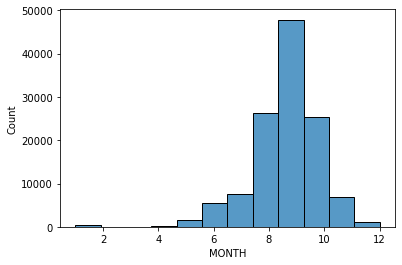

In [106]:
sns.histplot(x='MONTH',data=df_NA,bins=12)
plt.show()

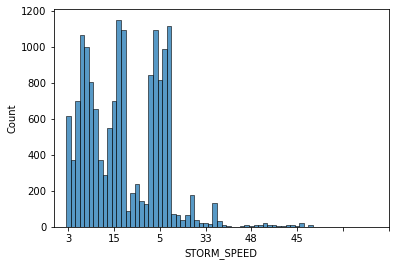

In [126]:
sns.histplot(x='STORM_SPEED',data=df_NA,bins=80)
plt.xticks(np.arange(0, 80, 10.0))
plt.show()

In [108]:
df_NA['YEAR'] = df_NA['ISO_TIME'].apply(lambda x: int(x.split('-')[0]))

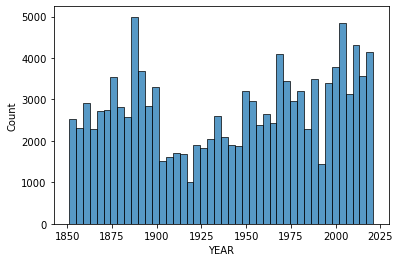

In [109]:
sns.histplot(x='YEAR',data=df_NA)
plt.show()

In [110]:
df_NA = df_NA[(df_NA['YEAR']>=2000) & 
              (df_NA['USA_STATUS'].apply(lambda x: any(x==y for y in ['TD','TS','DB','TC','HU','HR'])))]

In [111]:
storm_dates = pd.DataFrame()
storm_dates['MIN_DATE'] = df_NA.groupby('SID')['ISO_TIME'].apply(min)

In [112]:
storm_dates['MAX_DATE'] = df_NA.groupby('SID')['ISO_TIME'].apply(max)

In [113]:
storm_dates.reset_index(inplace=True)

**Making arrays of DATES, LABELS, LATS, LONS for each storm, along with first date/label and last date/label**

**Need data for "PRE-STORM" (PS) - could maybe take the day before the first date for this. Also need data for "CLEAR" (CL) - would have to take dates outside of hurricane season for this I suppose**

In [114]:
storm_dates['DATES'] = ''
storm_dates['LABELS'] = ''
storm_dates['LATS'] = ''
storm_dates['LONS'] = ''
storm_dates['INIT_LABEL'] = ''
storm_dates['FINAL_LABEL'] = ''
for i in range(storm_dates.shape[0]):
    min_date = storm_dates.iloc[i]['MIN_DATE']
    max_date = storm_dates.iloc[i]['MAX_DATE']
    sid = storm_dates.iloc[i]['SID']
    dates = df_NA[(df_NA['SID']==sid)]['ISO_TIME'].values
    labels = df_NA[(df_NA['SID']==sid)]['USA_STATUS'].values
    lats = df_NA[(df_NA['SID']==sid)]['LAT'].values
    lons = df_NA[(df_NA['SID']==sid)]['LON'].values
    storm_dates.at[i,'DATES']=dates
    storm_dates.at[i,'LABELS']=labels
    storm_dates.at[i,'LATS']=lats.astype(float)
    storm_dates.at[i,'LONS']=lons.astype(float)
    storm_dates.at[i,'INIT_LABEL']=labels[0]
    storm_dates.at[i,'FINAL_LABEL']=labels[-1]

In [115]:
storm_dates.sort_values(by='MAX_DATE',inplace=True,ascending=False)

In [116]:
storm_dates.head()

,SID,MIN_DATE,MAX_DATE,DATES,LABELS,LATS,LONS,INIT_LABEL,FINAL_LABEL
369,2021222N12339,2021-08-09 18:00:00,2021-08-15 00:00:00,"[2021-08-09 18:00:00, 2021-08-09 21:00:00, 202...","[DB, DB, DB, DB, DB, DB, DB, DB, DB, DB, DB, D...","[11.5, 11.5006, 11.5, 11.4997, 11.5, 11.4849, ...","[-20.6, -21.5025, -22.4, -23.2925, -24.2, -25....",DB,TS
368,2021220N11311,2021-08-07 18:00:00,2021-08-15 00:00:00,"[2021-08-07 18:00:00, 2021-08-07 21:00:00, 202...","[DB, DB, DB, DB, TS, TS, TS, TS, TS, TS, TS, T...","[11.2, 11.2452, 11.3, 11.3773, 17.4, 17.5984, ...","[-49.3, -49.7974, -50.3, -50.8201, -66.1, -66....",DB,DB
367,2021182N09317,2021-07-01 00:00:00,2021-07-09 15:00:00,"[2021-07-01 00:00:00, 2021-07-01 03:00:00, 202...","[TD, TD, TS, TS, TS, TS, TS, TS, TS, TS, TS, T...","[9.47143, 9.44726, 9.52153, 9.76311, 10.0603, ...","[-45.3571, -46.5276, -47.6854, -48.8909, -50.1...",TD,TS
366,2021178N28295,2021-06-26 12:00:00,2021-06-29 06:00:00,"[2021-06-26 12:00:00, 2021-06-26 15:00:00, 202...","[DB, DB, DB, DB, DB, DB, TD, TD, TS, TS, TS, T...","[28.2, 28.3034, 28.4, 28.492, 28.6, 28.7347, 3...","[-64.9, -65.6996, -66.5, -67.3003, -68.1, -68....",DB,DB
365,2021166N20265,2021-06-19 06:00:00,2021-06-22 00:00:00,"[2021-06-19 06:00:00, 2021-06-19 09:00:00, 202...","[TS, TS, TS, TS, TS, TS, TD, TD, TD, TD, TD, T...","[29.2, 29.8125, 30.5, 31.2031, 31.8, 32.1517, ...","[-91.0, -90.5977, -90.0, -89.2939, -88.6, -88....",TS,TS


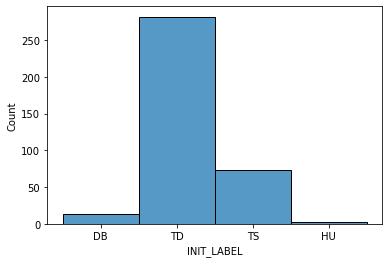

In [117]:
sns.histplot(x='INIT_LABEL',data=storm_dates)
plt.show()

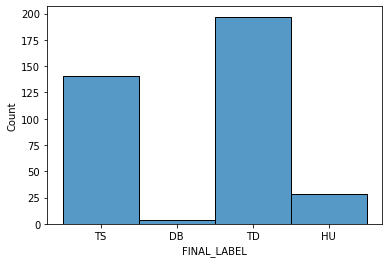

In [118]:
sns.histplot(x='FINAL_LABEL',data=storm_dates)
plt.show()

In [119]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [183]:
colors = {'CL':'cyan', 'PS':'blue', 'DB':'pink', 'TD':'purple', 'TS':'orange', 'HU':'red'}
color_map = lambda x: colors[x]

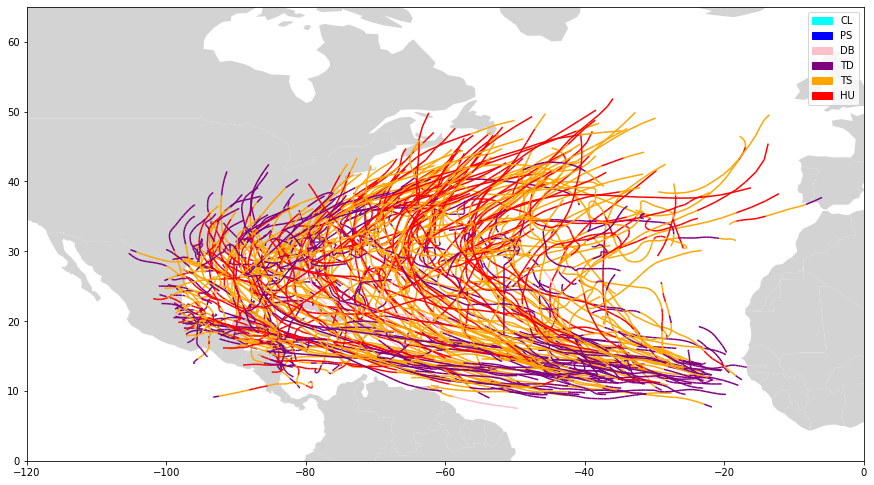

In [209]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(color="lightgrey",ax=ax)
for i in range(storm_dates.shape[0]):
    cmap = ListedColormap([color_map(x) for x in storm_dates.iloc[i]['LABELS']])
    x = storm_dates.iloc[i]['LONS']
    y = storm_dates.iloc[i]['LATS']
    xy = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    lc = LineCollection(segments, cmap = cmap)
    lc.set_array(y)
    ax.add_collection(lc)
    
plt.ylim(0,65)
plt.xlim(-120,0)

handles = []
for k,v in colors.items():

    handles.append(mpatches.Patch(color=v, label=k))

plt.legend(handles=handles)
plt.show()

In [122]:
storm_dates.to_csv('storm_dates.csv',index=False)

In [192]:
def extrapolate_backwards(lons,lats,dates,labels,ps_steps=5,cl_steps=5):
    
    new_lats = lats.copy()
    new_lons = lons.copy()
    new_dates = dates.copy()
    new_labels = labels.copy()

    #extrapolate backwards for ps_steps and call this "pre-storm"
    for i in range(1,ps_steps+1):
        new_lats = np.insert(new_lats,0,2*new_lats[0]-new_lats[1])
        new_lons = np.insert(new_lons,0,2*new_lons[0]-new_lons[1])
        new_date = (datetime.datetime.strptime(new_dates[0],'%Y-%m-%d %H:%M:%S')-datetime.timedelta(hours=3)).strftime('%Y-%m-%d %H:%M:%S')
        new_dates = np.insert(new_dates,0,new_date)
        new_labels = np.insert(new_labels,0,'PS')
        
    #extrapolate backward for cl_steps and call this "clear"    
    for i in range(1,cl_steps+1):
        new_lats = np.insert(new_lats,0,2*new_lats[0]-new_lats[1])
        new_lons = np.insert(new_lons,0,2*new_lons[0]-new_lons[1])
        new_date = (datetime.datetime.strptime(new_dates[0],'%Y-%m-%d %H:%M:%S')-datetime.timedelta(hours=3)).strftime('%Y-%m-%d %H:%M:%S')
        new_dates = np.insert(new_dates,0,new_date)
        new_labels = np.insert(new_labels,0,'CL')    
        
    return new_lons,new_lats,new_dates,new_labels
        

In [189]:
extrap_storm_dates = storm_dates.copy()

In [201]:
for i in range(storm_dates.shape[0]):
    lons,lats,dates,labels = extrapolate_backwards(storm_dates.iloc[i]['LONS'],
                                                   storm_dates.iloc[i]['LATS'],
                                                   storm_dates.iloc[i]['DATES'],
                                                   storm_dates.iloc[i]['LABELS'],
                                                   ps_steps=8,
                                                   cl_steps=15)
    
    extrap_storm_dates.at[i,'LONS']=lons
    extrap_storm_dates.at[i,'LATS']=lats
    extrap_storm_dates.at[i,'DATES']=dates
    extrap_storm_dates.at[i,'LABELS']=labels

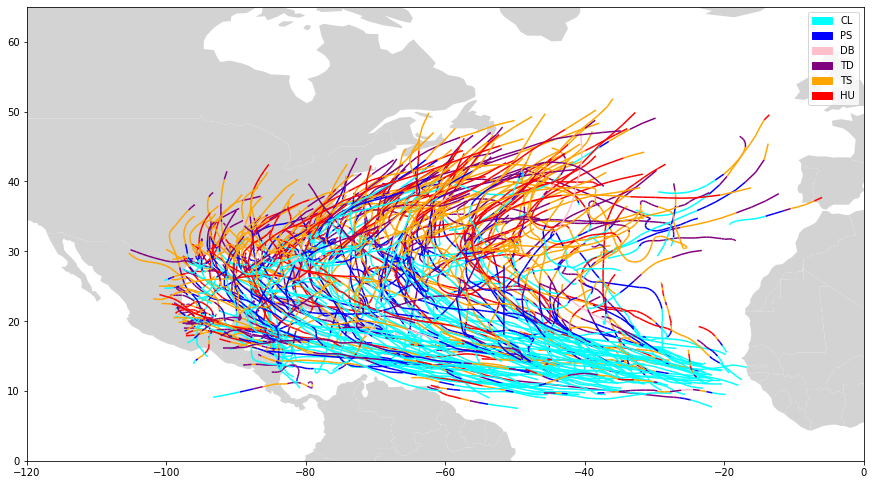

In [211]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(color="lightgrey",ax=ax)
for i in range(storm_dates.shape[0]):
    cmap = ListedColormap([color_map(x) for x in extrap_storm_dates.iloc[i]['LABELS']])
    x = storm_dates.iloc[i]['LONS']
    y = storm_dates.iloc[i]['LATS']
    xy = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])
    lc = LineCollection(segments, cmap = cmap)
    lc.set_array(y)
    ax.add_collection(lc)
    
plt.ylim(0,65)
plt.xlim(-120,0)

handles = []
for k,v in colors.items():

    handles.append(mpatches.Patch(color=v, label=k))

plt.legend(handles=handles)
plt.show()